In [63]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from Bio.PDB import MMCIFParser


def afm3_plot(af3_json, af3_pdb, pae_cutoff=12):
    json_data = json.load(open(af3_json,'rb'))
    # contact_probs = np.array(json_data['contact_probs'])
    # atom_chain_ids = np.array(json_data['atom_chain_ids'])
    parser = MMCIFParser()
    structure = parser.get_structure("protein_name", af3_pdb)

    chain_lengths = {}

    # Iterate over all chains in the structure
    for chain in structure.get_chains():
        # Count the number of residues in this chain
        chain_length = len(list(chain.get_residues()))
        chain_lengths[chain.id] = chain_length
    
    subunit_number = list(chain_lengths.values())

    # Extract the PAE matrix
    pae_matrix = np.array(json_data['pae'])

    # Number of residues per subunit (example values, replace with your actual data)
    subunit_sizes = subunit_number

    # Create boundary lines based on subunit sizes
    boundaries = np.cumsum(subunit_sizes)

    # Plotting the PAE matrix
    fig, ax = plt.subplots(figsize=(5, 5))
    cax = ax.matshow(pae_matrix, cmap='bwr')

    # Adding interface boundaries
    for boundary in boundaries[:-1]:
        ax.add_patch(Rectangle((boundary, 0), 0.5, len(pae_matrix), edgecolor='black', fill=False, linewidth=2))
        ax.add_patch(Rectangle((0, boundary), len(pae_matrix), 0.5, edgecolor='black', fill=False, linewidth=2))

    # Adding color bar
    fig.colorbar(cax, label='Predicted Aligned Error (PAE)', shrink=0.8)

    # Adding titles and labels
    ax.set_title('Predicted Aligned Error (PAE) Map')
    # ax.set_xlabel('Residue Index')
    # ax.set_ylabel('Residue Index')

    # Move x-axis to bottom
    ax.xaxis.tick_bottom()


    # Show plot
    plt.show()

    # Function to transform the PAE matrix based on specified rules
    def transform_pae_matrix(pae_matrix, pae_cutoff):
        # Initialize the transformed matrix with zeros
        transformed_pae = np.zeros_like(pae_matrix)

        # Apply transformation: pae = 0 -> score = 1, pae = cutoff -> score = 0, above cutoff -> score = 0
        # Linearly scale values between 0 and cutoff to fall between 1 and 0
        within_cutoff = pae_matrix < pae_cutoff
        transformed_pae[within_cutoff] = 1 - (pae_matrix[within_cutoff] / pae_cutoff)
        
        return transformed_pae

    # Example PAE matrix, replace this with your actual data load
    # pae_matrix = pae 
    pae_cutoff = 12  # Define a cutoff for PAE values

    # Transform the PAE matrix
    transformed_pae_matrix = transform_pae_matrix(pae_matrix, pae_cutoff)

    # Number of residues per subunit (example values, replace with your actual data)
    subunit_sizes = subunit_number

    # Create boundary lines based on subunit sizes
    boundaries = np.cumsum(subunit_sizes)

    # Plotting the PAE matrix
    fig, ax = plt.subplots(figsize=(5, 5))
    cax = ax.matshow(transformed_pae_matrix, cmap='Blues')

    # Adding interface boundaries
    for boundary in boundaries[:-1]:
        ax.add_patch(Rectangle((boundary, 0), 0.5, len(pae_matrix), edgecolor='black', fill=False, linewidth=2))
        ax.add_patch(Rectangle((0, boundary), len(pae_matrix), 0.5, edgecolor='black', fill=False, linewidth=2))

    # Adding color bar
    fig.colorbar(cax, label='Local Interaction Score (LIS)', shrink=0.8)

    # Adding titles and labels
    ax.set_title('Local Interaction Area (LIA) Map')
    # ax.set_xlabel('Residue Index')
    # ax.set_ylabel('Residue Index')

    # Move x-axis to bottom
    ax.xaxis.tick_bottom()

    # Show plot
    plt.show()

    def calculate_mean_lis(transformed_pae, subunit_number):
        # Calculate the cumulative sum of protein lengths to get the end indices of the submatrices
        cum_lengths = np.cumsum(subunit_number)
        
        # Add a zero at the beginning of the cumulative lengths to get the start indices
        start_indices = np.concatenate(([0], cum_lengths[:-1]))
        
        # Initialize an empty matrix to store the mean LIS
        mean_lis_matrix = np.zeros((len(subunit_number), len(subunit_number)))
        
        # Iterate over the start and end indices
        for i in range(len(subunit_number)):
            for j in range(len(subunit_number)):
                # Get the start and end indices of the interaction submatrix
                start_i, end_i = start_indices[i], cum_lengths[i]
                start_j, end_j = start_indices[j], cum_lengths[j]
                
                # Get the interaction submatrix
                submatrix = transformed_pae[start_i:end_i, start_j:end_j]
                
                # Calculate the mean LIS, considering only non-zero values
                mean_lis = submatrix[submatrix > 0].mean()
                
                # Store the mean LIS in the matrix
                mean_lis_matrix[i, j] = mean_lis
        
        return mean_lis_matrix

    # Calculate the mean LIS matrix
    mean_lis_matrix = calculate_mean_lis(transformed_pae_matrix, subunit_sizes)

    # Plot the mean LIS matrix as a heatmap
    plt.figure(figsize=(5, 5))
    plt.imshow(mean_lis_matrix, cmap='magma_r', interpolation='nearest')
    plt.colorbar(label='LIS', shrink=0.8)
    plt.title('LIS heatmap among subunits')

    # Subunit labels
    subunit_labels = [i for i in range(1, len(subunit_sizes)+1)]

    # Add xtick and ytick labels
    plt.xticks(np.arange(len(subunit_sizes)), subunit_labels)
    plt.yticks(np.arange(len(subunit_sizes)), subunit_labels)

    # Add scores to the heatmap
    for i in range(len(subunit_sizes)):
        for j in range(len(subunit_sizes)):
            plt.text(j, i, format(mean_lis_matrix[i, j], '.3f'), ha='center', va='center', color='w')
    
    plt.show()

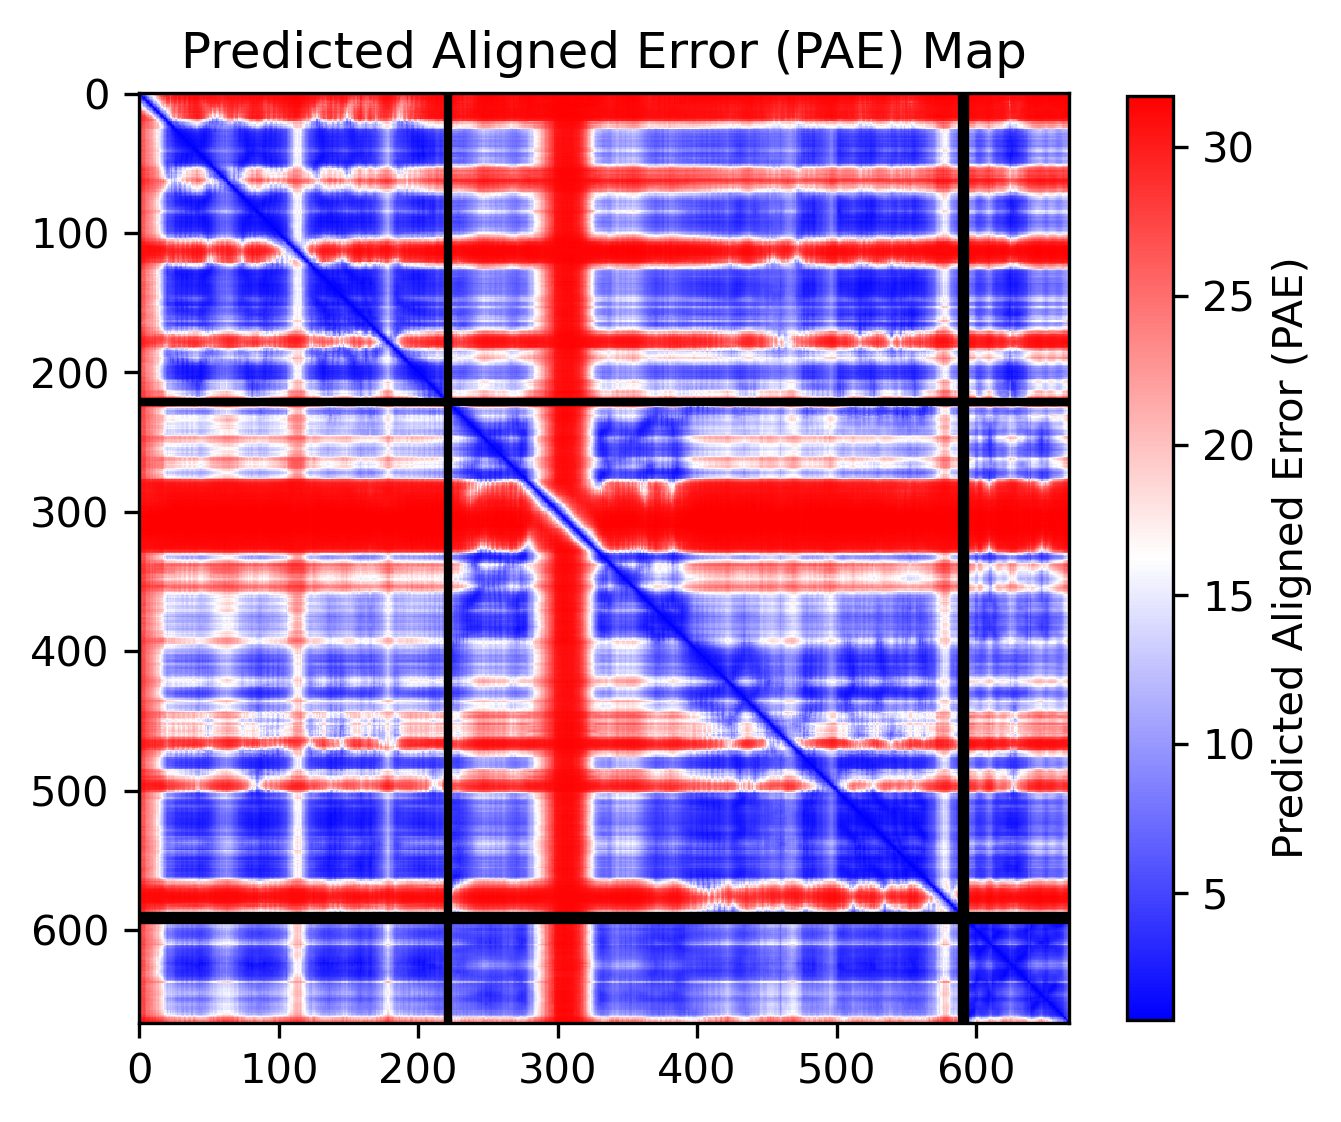

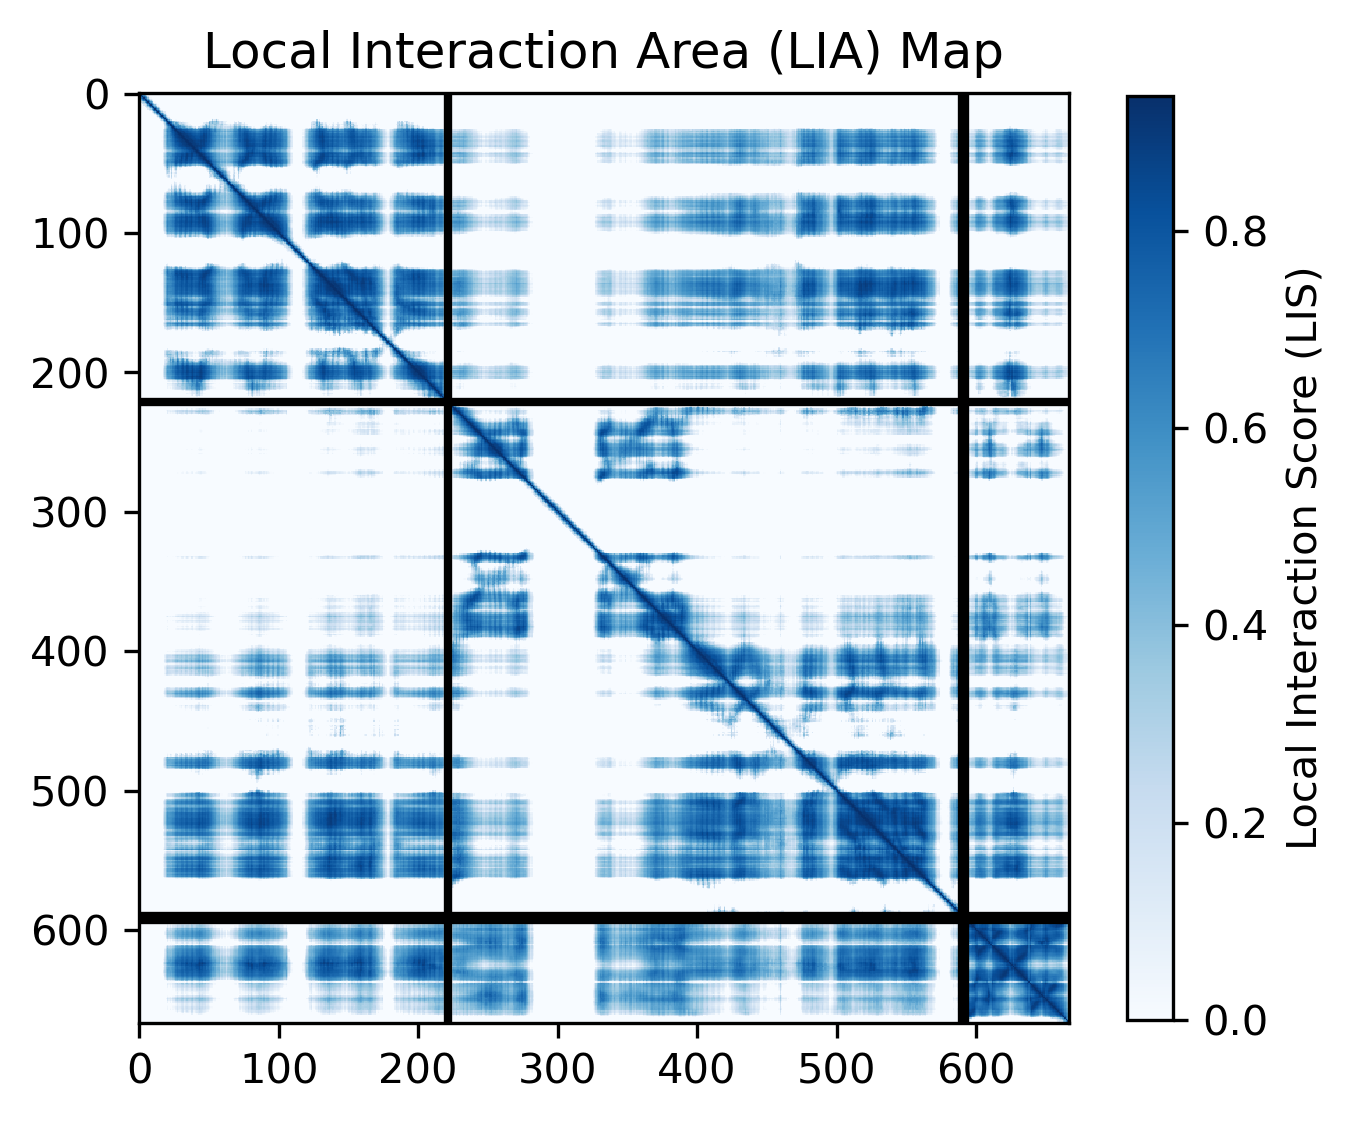

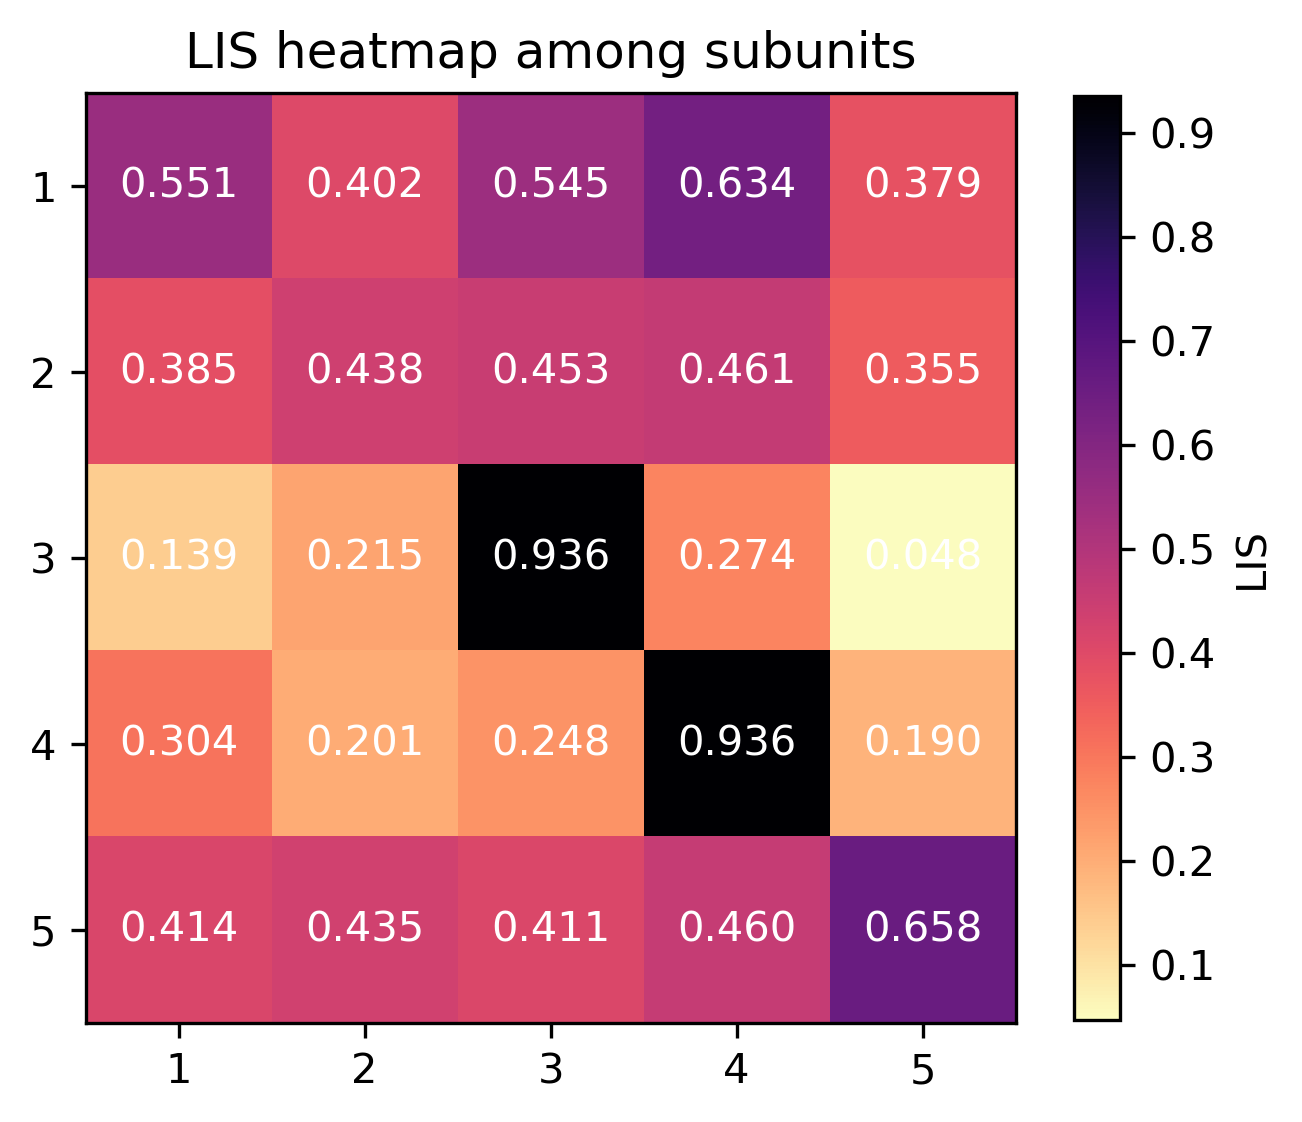

In [64]:
af3_json = "./alphafold3/examplefold_pdb_8aw3/examplefold_pdb_8aw3_full_data_0.json"
af3_structure = "./alphafold3/examplefold_pdb_8aw3/examplefold_pdb_8aw3_model_0.cif"
pae_cutoff = 12
afm3_plot(af3_json, af3_structure, pae_cutoff)

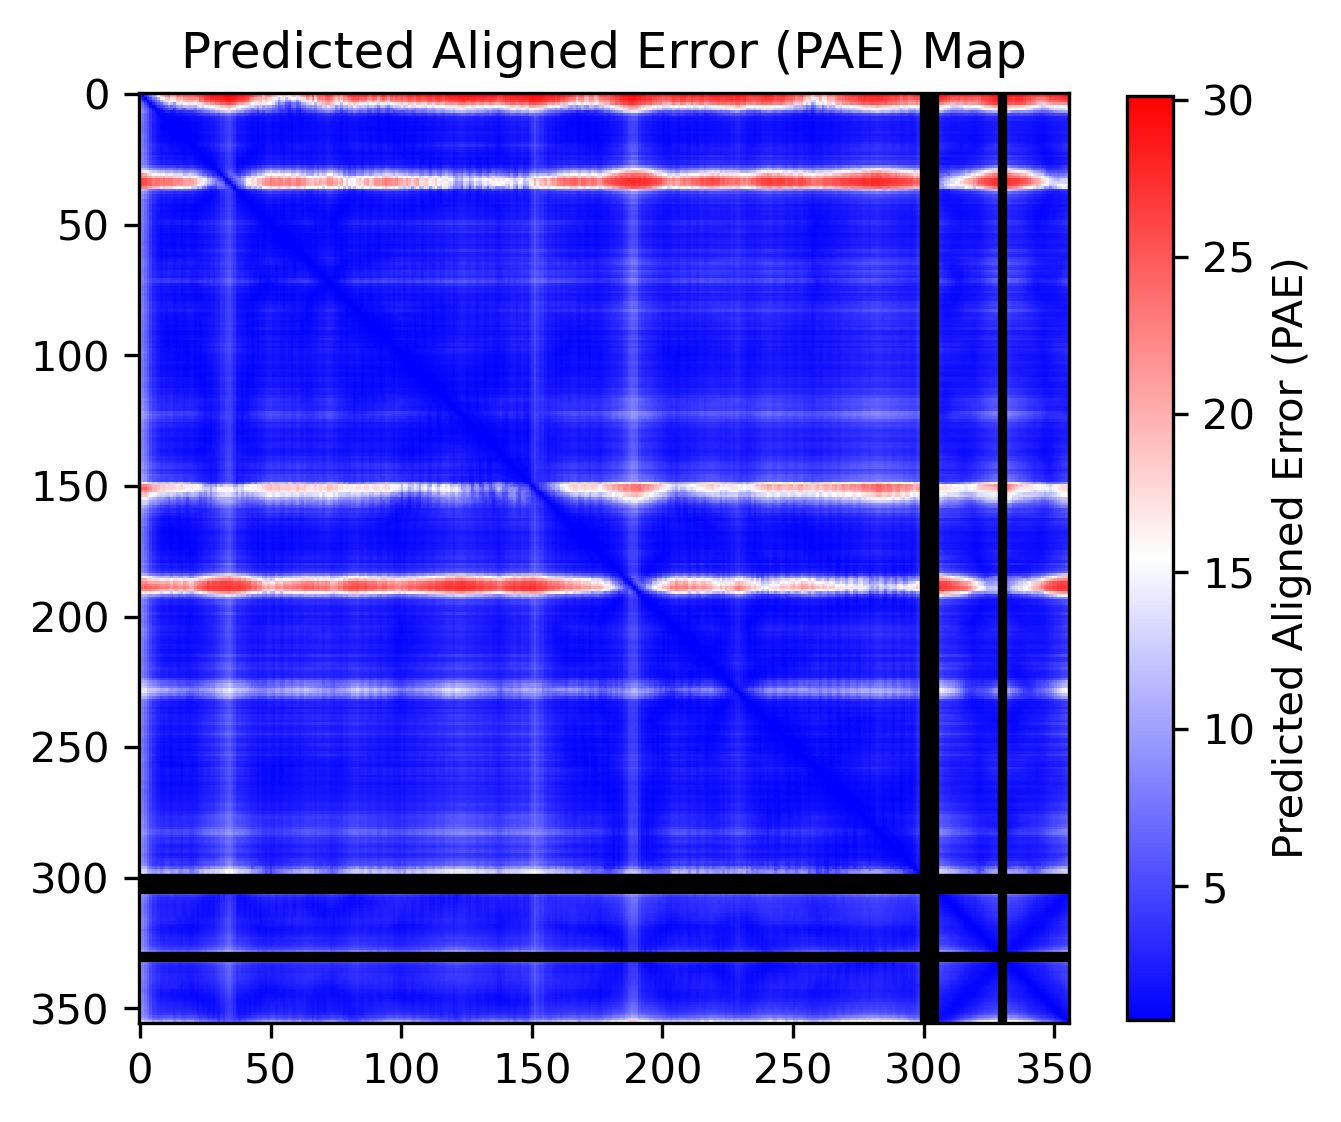

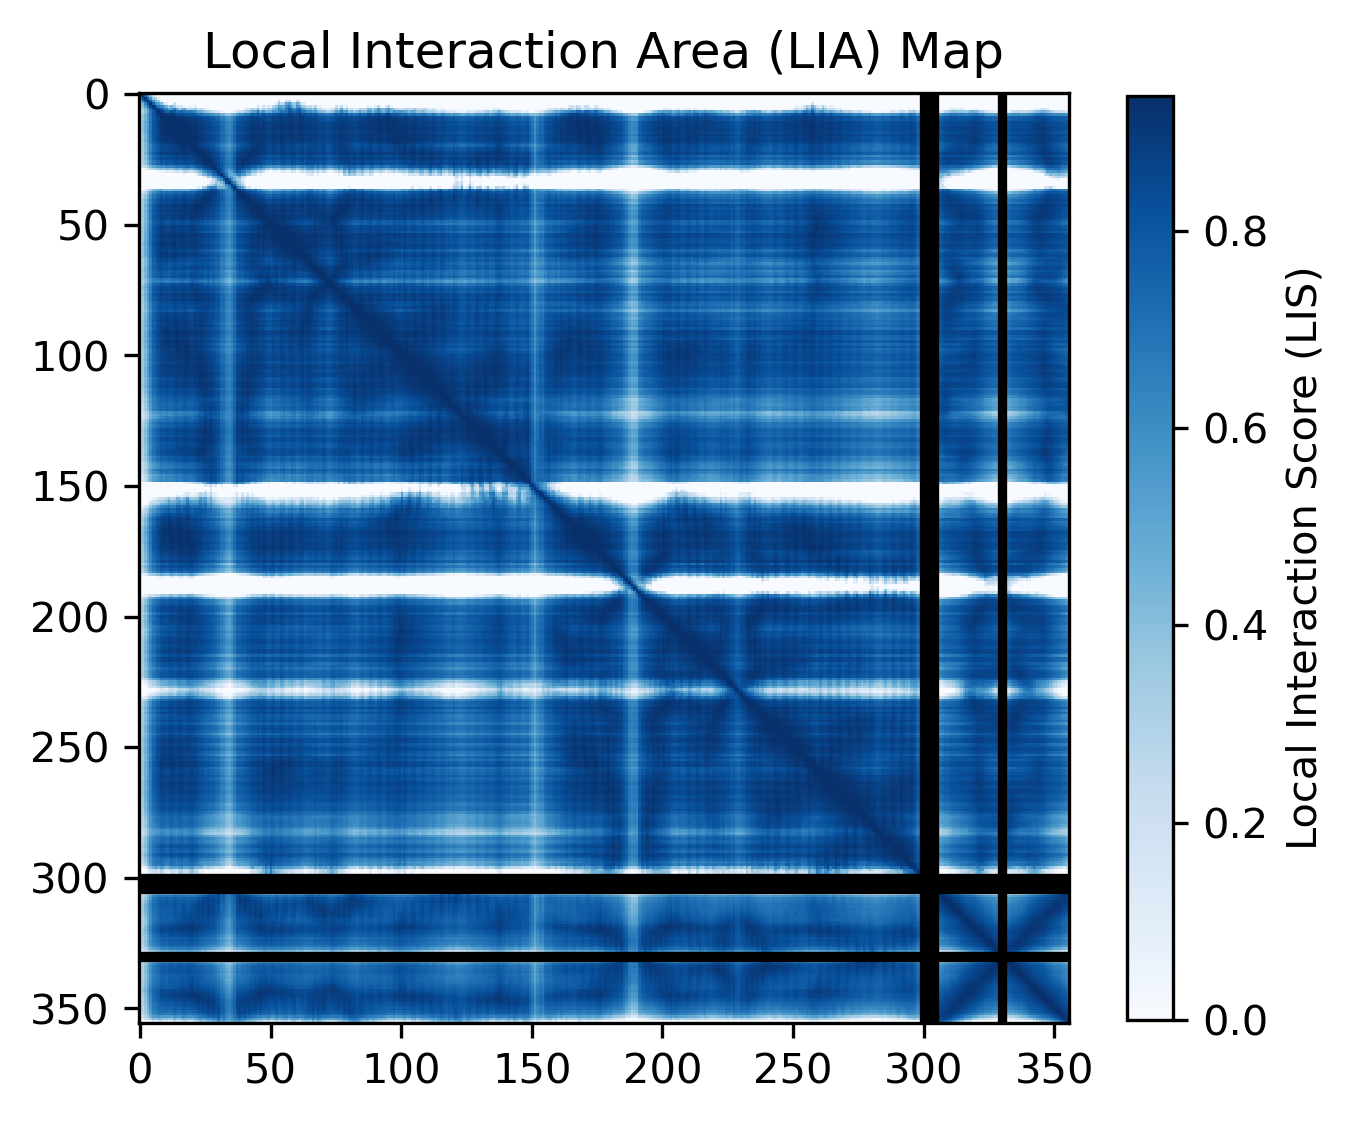

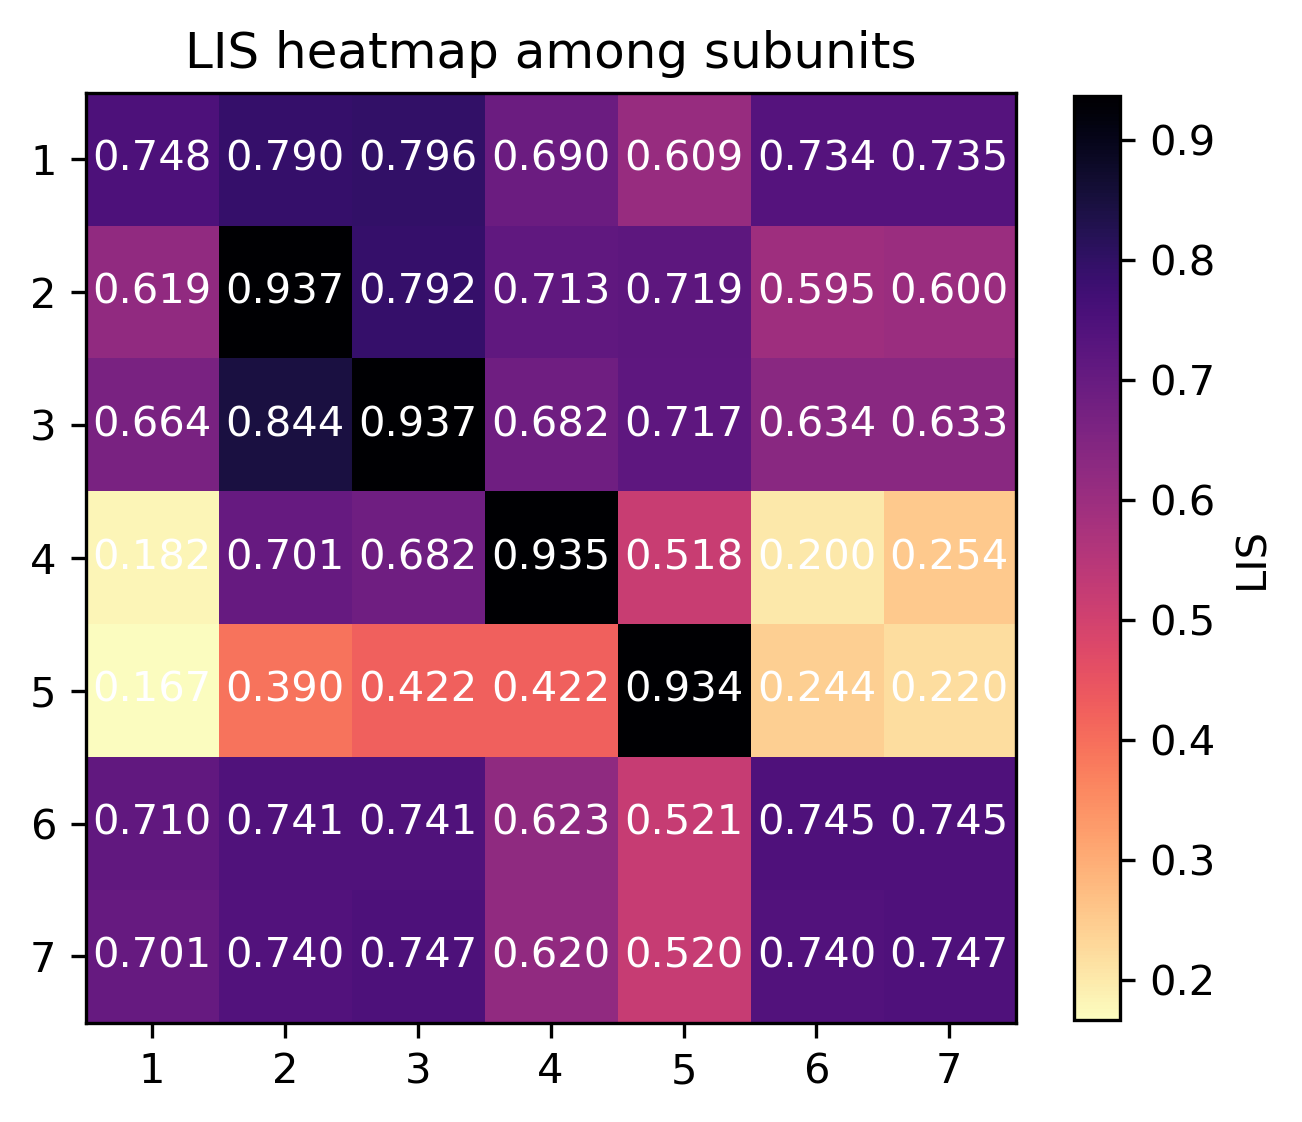

In [65]:
af3_json = "./alphafold3/examplefold_pdb_7rce/examplefold_pdb_7rce_full_data_0.json"
af3_structure = "./alphafold3/examplefold_pdb_7rce/examplefold_pdb_7rce_model_0.cif"

pae_cutoff = 12
afm3_plot(af3_json, af3_structure, pae_cutoff)

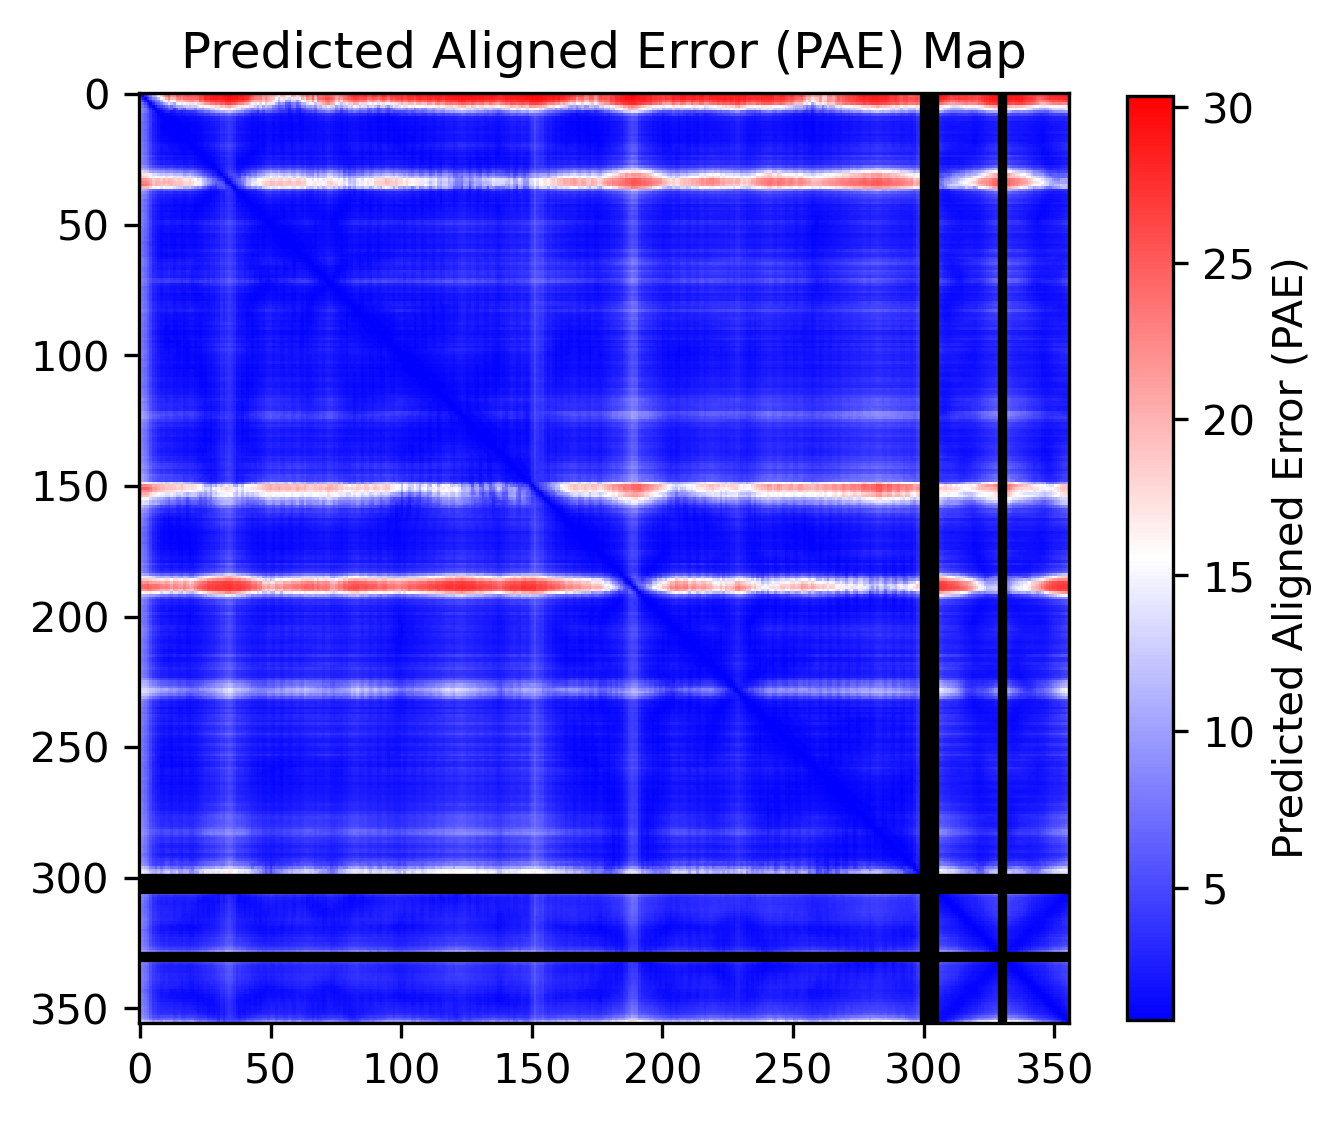

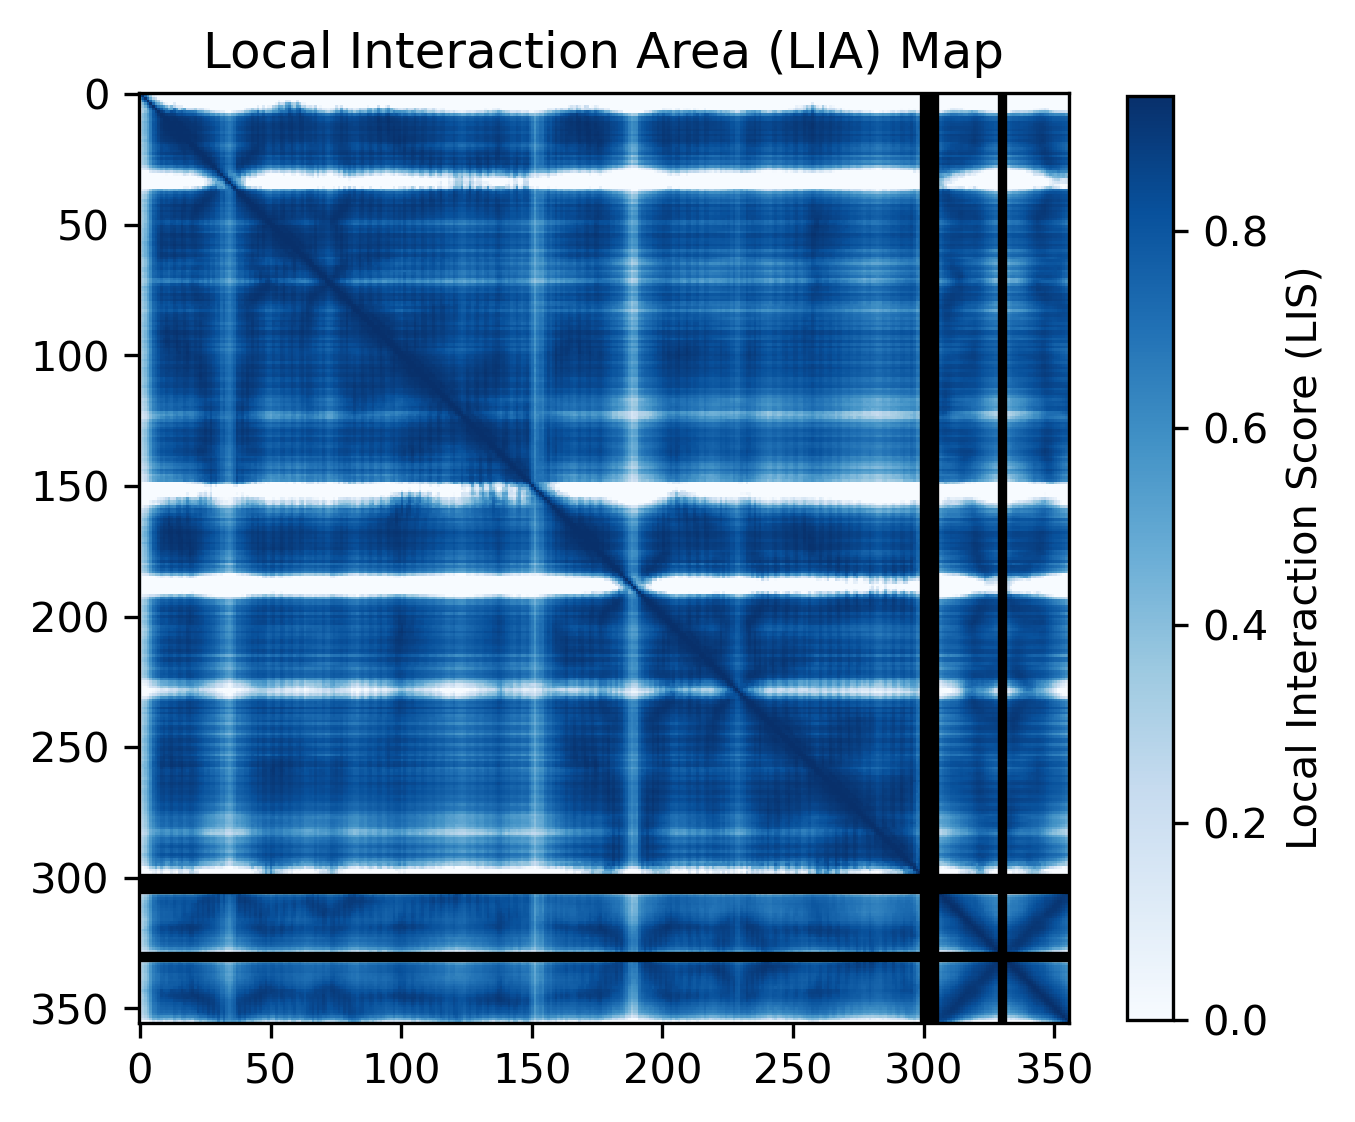

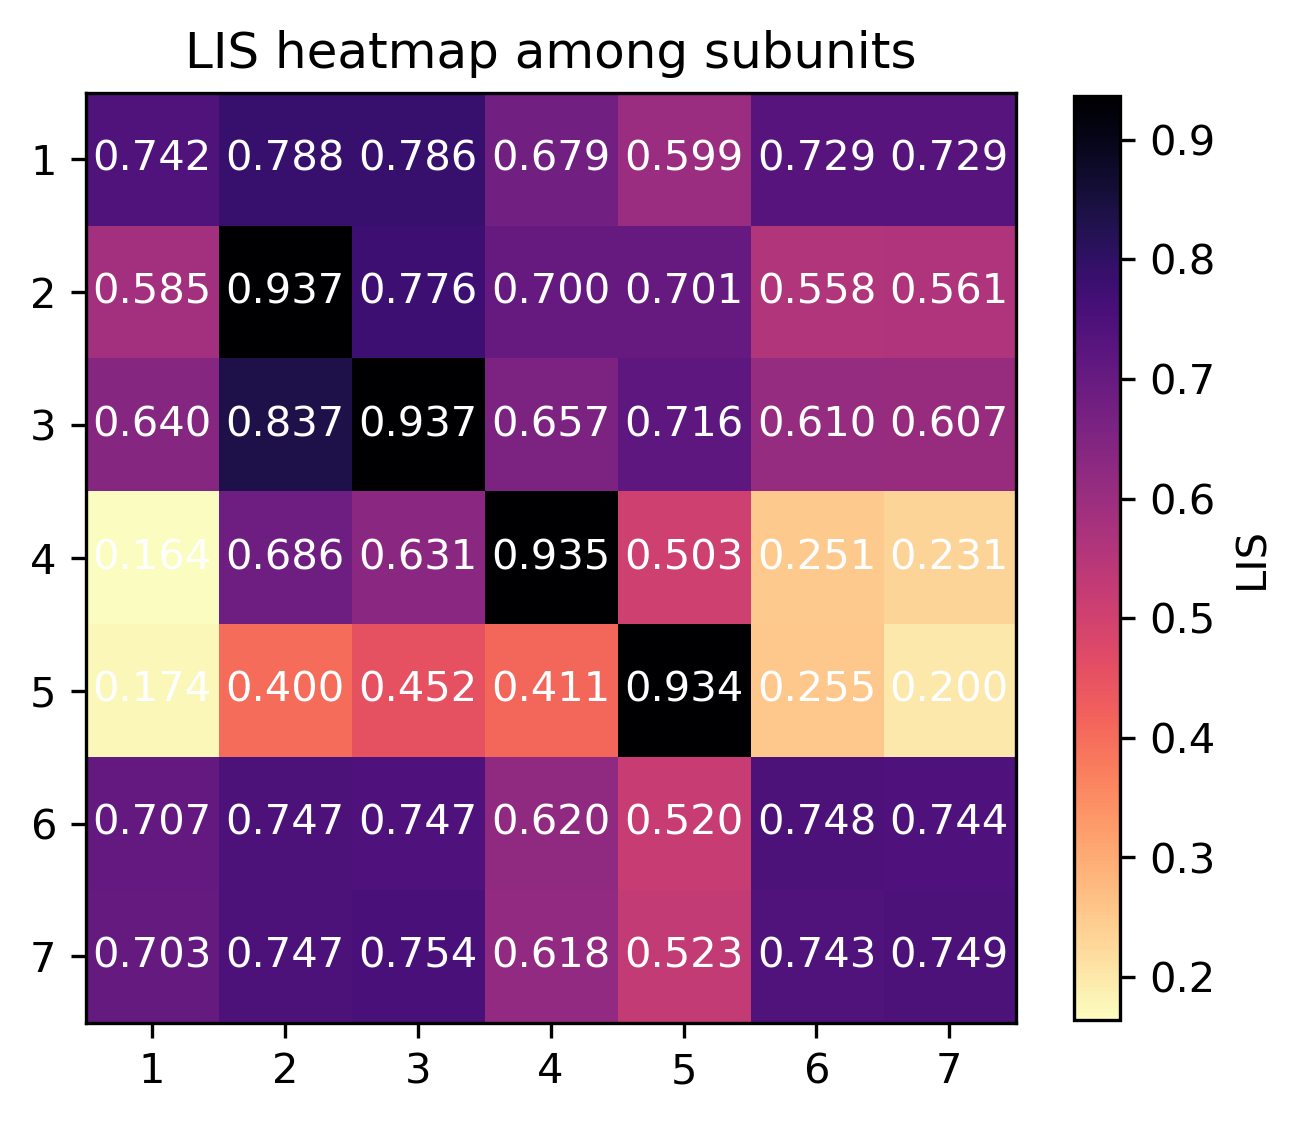

In [67]:
af3_json = "./alphafold3/examplefold_pdb_7rce/examplefold_pdb_7rce_full_data_1.json"
af3_structure = "./alphafold3/examplefold_pdb_7rce/examplefold_pdb_7rce_model_1.cif"

pae_cutoff = 12
afm3_plot(af3_json, af3_structure, pae_cutoff)